# Run Correlation-Based Analyses

### Authors: Calvin Howard.

#### Last updated: July 6, 2023

Use this to assess if a correlation between a dependent variable and an independent variable is statistically significant using permutation analysis. 

Further, follow this up with a contrast analysis which sees which categorical variables have significantly different correlations from each other. 

Notes:
- To best use this notebook, you should be familar with mixed effects models

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

In [56]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/metadata/demographics.csv'
sheet = None #'master_list_proper_subjects' 

In [57]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/merge_f2_f4'

In [58]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [59]:
data_df.columns

Index(['subject', 'Cognitive_Test', 'Baseline_Cognitive_Score',
       'Normalized_Cognitive_Basleline', 'Standardized_Cognitive_Baseline',
       'Cognitively_Improved', 'Sex', 'Age', 'Hippocampus_GM_Volume__mL_',
       'Subiculum_Connectivity__T_', 'Frequency', 'Pulse_Width__uS_',
       'Amperage__mA_', 'Parahippocampal_Gyrus_GM_Vol',
       'Entorhinal_Cortex_GM_Vol', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivit

In [60]:
drop_list = ['Z_Scored_Percent_Cognitive_Improvement']

In [61]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

,subject,Cognitive_Test,Baseline_Cognitive_Score,Normalized_Cognitive_Basleline,Standardized_Cognitive_Baseline,Cognitively_Improved,Sex,Age,Hippocampus_GM_Volume__mL_,Subiculum_Connectivity__T_,...,DECLINE,Cognitive_Improve,Z_Scored_Cognitive_Baseline,Z_Scored_Cognitive_Baseline__Lower_is_Better_,Min_Max_Normalized_Baseline,MinMaxNormBaseline_Higher_is_Better,ROI_to_Alz_Max,ROI_to_PD_Max,Standardzied_AD_Max,Standardized_PD_Max
0,101,ADAS-Cog 11,28.0,0.600000,-1.539791,0,f,62,5.8883,21.150595,...,True,No,1.518764,-1.518764,0.72,0.28,12.222658,14.493929,-1.714513,-1.227368
1,102,ADAS-Cog 11,22.0,0.685714,-0.490452,0,f,77,3.7634,19.702349,...,True,No,0.465551,-0.465551,0.48,0.52,14.020048,15.257338,-1.155843,-1.022243
2,103,ADAS-Cog 11,19.0,0.728571,0.034218,0,m,76,4.8575,23.231614,...,True,No,-0.061056,0.061056,0.36,0.64,15.118727,17.376384,-0.814348,-0.452865
3,104,ADAS-Cog 11,17.0,0.757143,0.383997,0,f,65,4.8569,22.172312,...,True,No,-0.412127,0.412127,0.28,0.72,13.112424,15.287916,-1.437954,-1.014027
4,105,ADAS-Cog 11,19.0,0.728571,0.034218,0,f,50,5.9636,21.546222,...,False,No,-0.061056,0.061056,0.36,0.64,15.086568,12.951426,-0.824344,-1.641831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,52,UPDRS-1,NaN,0.000000,-0.891338,0,f,53,8.5137,15.900000,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,53,UPDRS-1,NaN,0.000000,-0.891338,0,m,59,8.2139,30.100000,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,55,UPDRS-1,1.0,0.250000,0.185695,0,f,62,5.3292,29.800000,...,False,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,56,UPDRS-1,1.0,0.250000,0.185695,0,m,55,5.1925,34.600000,...,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

Set the parameters for dropping rows

In [62]:
data_df.columns
# data_df.City.unique()

Index(['subject', 'Cognitive_Test', 'Baseline_Cognitive_Score',
       'Normalized_Cognitive_Basleline', 'Standardized_Cognitive_Baseline',
       'Cognitively_Improved', 'Sex', 'Age', 'Hippocampus_GM_Volume__mL_',
       'Subiculum_Connectivity__T_', 'Frequency', 'Pulse_Width__uS_',
       'Amperage__mA_', 'Parahippocampal_Gyrus_GM_Vol',
       'Entorhinal_Cortex_GM_Vol', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivit

In [63]:
column = 'Cognitive_Test'  # The column you'd like to evaluate
condition = 'equal'  # Thecondition to check ('equal', 'above', 'below', 'not')
value = 'UPDRS-1' # The value to compare against

In [64]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
data_df

,subject,Cognitive_Test,Baseline_Cognitive_Score,Normalized_Cognitive_Basleline,Standardized_Cognitive_Baseline,Cognitively_Improved,Sex,Age,Hippocampus_GM_Volume__mL_,Subiculum_Connectivity__T_,...,DECLINE,Cognitive_Improve,Z_Scored_Cognitive_Baseline,Z_Scored_Cognitive_Baseline__Lower_is_Better_,Min_Max_Normalized_Baseline,MinMaxNormBaseline_Higher_is_Better,ROI_to_Alz_Max,ROI_to_PD_Max,Standardzied_AD_Max,Standardized_PD_Max
0,101,ADAS-Cog 11,28.0,0.600000,-1.539791,0,f,62,5.8883,21.150595,...,True,No,1.518764,-1.518764,0.720,0.280,12.222658,14.493929,-1.714513,-1.227368
1,102,ADAS-Cog 11,22.0,0.685714,-0.490452,0,f,77,3.7634,19.702349,...,True,No,0.465551,-0.465551,0.480,0.520,14.020048,15.257338,-1.155843,-1.022243
2,103,ADAS-Cog 11,19.0,0.728571,0.034218,0,m,76,4.8575,23.231614,...,True,No,-0.061056,0.061056,0.360,0.640,15.118727,17.376384,-0.814348,-0.452865
3,104,ADAS-Cog 11,17.0,0.757143,0.383997,0,f,65,4.8569,22.172312,...,True,No,-0.412127,0.412127,0.280,0.720,13.112424,15.287916,-1.437954,-1.014027
4,105,ADAS-Cog 11,19.0,0.728571,0.034218,0,f,50,5.9636,21.546222,...,False,No,-0.061056,0.061056,0.360,0.640,15.086568,12.951426,-0.824344,-1.641831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,38,MDRS,144.0,1.000000,1.102139,0,m,52,NaN,14.611144,...,False,No,1.114522,1.114522,1.000,1.000,5.944940,9.801099,-1.714504,-0.960505
75,39,MDRS,142.0,0.986111,0.275535,0,m,58,NaN,21.551613,...,True,No,0.294644,0.294644,0.750,0.750,14.657576,16.050861,-0.212787,-0.099789
76,43,MDRS,141.0,0.979167,-0.137767,0,f,60,NaN,20.200341,...,False,No,-0.115295,-0.115295,0.625,0.625,13.809253,9.428111,-0.359005,-1.011872
77,44,MDRS,143.0,0.993056,0.688837,0,f,59,NaN,14.468351,...,False,Yes,0.704583,0.704583,0.875,0.875,10.861661,3.594913,-0.867054,-1.815218


Regress out a Covariate

In [65]:
lis = []
for col in data_df.columns:
    if 'surface' in col.lower():
        lis.append(col)
print(lis)

[]


In [66]:
from calvin_utils.statistical_utils.regression_utils import RegressOutCovariates
# use this code block to regress out covariates. Generally better to just include as covariates in a model..
dependent_variable_list = lis
regressors = ['Age', 'Sex']

# data_df, adjusted_dep_vars_list = RegressOutCovariates.run(df=data_df, dependent_variable_list=dependent_variable_list, covariates_list=regressors)
# print(adjusted_dep_vars_list)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [67]:
data_df.columns

Index(['subject', 'Cognitive_Test', 'Baseline_Cognitive_Score',
       'Normalized_Cognitive_Basleline', 'Standardized_Cognitive_Baseline',
       'Cognitively_Improved', 'Sex', 'Age', 'Hippocampus_GM_Volume__mL_',
       'Subiculum_Connectivity__T_', 'Frequency', 'Pulse_Width__uS_',
       'Amperage__mA_', 'Parahippocampal_Gyrus_GM_Vol',
       'Entorhinal_Cortex_GM_Vol', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivit

In [68]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['Cohort', 'Age', 'Z_Scored_Percent_Cognitive_Improvement', 'MinMaxNormBaseline_Higher_is_Better']

In [69]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

Unable to standardize column Cognitive_Test.
Unable to standardize column Sex.
Unable to standardize column Disease.
Unable to standardize column City.
Unable to standardize column Age_Group.
Unable to standardize column Age_And_Disease.
Unable to standardize column Age_Disease_and_Cohort.
Unable to standardize column Age_Disease_Cohort_Stim.
Unable to standardize column Age_And_Stim.
Unable to standardize column Subiculum_Group_By_Z_Score_Sign.
Unable to standardize column Subiculum_Group_By_Inflection_Point.
Unable to standardize column Subiculum_Group_By_24.
Unable to standardize column Cognitive_Outcome.
Unable to standardize column StimMatch.
Unable to standardize column StimMatch24.
Unable to standardize column Cognitive_Improve.


/Users/cu135/Library/CloudStorage/OneDrive-Personal/OneDrive_Documents/Work/Software/calvin_utils_project/calvin_utils_project/calvin_utils/permutation_analysis_utils/statsmodels_palm.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.34939579  0.36837947  0.38736315  0.40634683  0.4253305   0.44431418
  0.46329786  0.48228154  0.50126521  0.52024889  0.53923257  0.57719993
  0.5961836   0.61516728  0.63415096  0.67211832  0.69110199  0.71008567
  0.72906935  0.74805303  0.7670367   0.78602038  0.80500406  0.82398774
  0.84297142  0.86195509  0.88093877  0.89992245  0.91890613  0.95687348
  0.97585716  0.99484084  1.03280819  1.05179187  1.07077555  1.08975923
  1.10874291  1.12772658  1.14671026  1.16569394  1.18467762  1.2036613
  1.22264497  1.24162865  1.26061233  1.27959601 -1.54897199 -1.52998831
 -1.51100464 -1.49202096 -1.4540536  -1.43506993 -1.39710257 -1.35913521
 -1.34015154 -1.3021841

,subject,Cognitive_Test,Baseline_Cognitive_Score,Normalized_Cognitive_Basleline,Standardized_Cognitive_Baseline,Cognitively_Improved,Sex,Age,Hippocampus_GM_Volume__mL_,Subiculum_Connectivity__T_,...,DECLINE,Cognitive_Improve,Z_Scored_Cognitive_Baseline,Z_Scored_Cognitive_Baseline__Lower_is_Better_,Min_Max_Normalized_Baseline,MinMaxNormBaseline_Higher_is_Better,ROI_to_Alz_Max,ROI_to_PD_Max,Standardzied_AD_Max,Standardized_PD_Max
0,0.349396,ADAS-Cog 11,-0.698807,-1.652166,-1.559660,-0.464095,f,62,-0.001606,-0.550922,...,1.180652,No,1.534417,-1.552545,0.756677,0.280,-1.036718,-0.604781,-1.728415,-1.202464
1,0.368379,ADAS-Cog 11,-0.798128,-1.043308,-0.496781,-0.464095,f,77,-1.196558,-0.830661,...,1.180652,No,0.464063,-0.482191,-0.054782,0.520,-0.638644,-0.470800,-1.161587,-0.997667
2,0.387363,ADAS-Cog 11,-0.847788,-0.738879,0.034659,-0.464095,m,76,-0.581283,-0.148958,...,1.180652,No,-0.071113,0.052986,-0.460512,0.640,-0.395317,-0.098899,-0.815105,-0.429200
3,0.406347,ADAS-Cog 11,-0.880895,-0.535926,0.388952,-0.464095,f,65,-0.581621,-0.353570,...,1.180652,No,-0.427898,0.409770,-0.730998,0.720,-0.839659,-0.465433,-1.447817,-0.989464
4,0.425331,ADAS-Cog 11,-0.847788,-0.738879,0.034659,-0.464095,f,50,0.040740,-0.474503,...,-0.84699,No,-0.071113,0.052986,-0.460512,0.640,-0.402439,-0.875496,-0.825247,-1.616265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,-0.846576,MDRS,1.221394,1.189172,1.116360,-0.464095,m,52,NaN,-1.814064,...,-0.84699,No,1.123596,1.123596,1.703379,1.000,-2.427063,-1.428391,-1.728406,-0.936028
75,-0.827592,MDRS,1.188287,1.090514,0.279090,-0.464095,m,58,NaN,-0.473462,...,1.180652,No,0.290375,0.290375,0.858109,0.750,-0.497449,-0.331533,-0.204759,-0.076689
76,-0.751658,MDRS,1.171733,1.041185,-0.139545,-0.464095,f,60,NaN,-0.734470,...,-0.84699,No,-0.126236,-0.126236,0.435474,0.625,-0.685330,-1.493851,-0.353112,-0.987313
77,-0.732674,MDRS,1.204840,1.139843,0.697725,-0.464095,f,59,NaN,-1.841645,...,-0.84699,Yes,0.706985,0.706985,1.280744,0.875,-1.338142,-2.517600,-0.868580,-1.789375


In [70]:
data_df.describe()

,subject,Baseline_Cognitive_Score,Normalized_Cognitive_Basleline,Standardized_Cognitive_Baseline,Cognitively_Improved,Age,Hippocampus_GM_Volume__mL_,Subiculum_Connectivity__T_,Frequency,Pulse_Width__uS_,...,MinMaxNorm_Cog_Score_1_Yr,Abs_Cognitive_Improve,Z_Scored_Cognitive_Baseline,Z_Scored_Cognitive_Baseline__Lower_is_Better_,Min_Max_Normalized_Baseline,MinMaxNormBaseline_Higher_is_Better,ROI_to_Alz_Max,ROI_to_PD_Max,Standardzied_AD_Max,Standardized_PD_Max
count,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01,79.000000,7.200000e+01,7.900000e+01,7.900000e+01,7.900000e+01,...,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01,79.000000,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01
mean,2.810691e-17,-1.011849e-16,1.742629e-16,2.529622e-17,8.432074e-18,63.278481,-4.471732e-17,-2.923119e-16,-8.094791e-16,2.417194e-16,...,-3.260402e-16,-1.405346e-17,-1.124276e-17,-1.686415e-17,-1.068063e-16,0.643038,9.893633e-16,5.171672e-16,-5.621382e-18,-2.248553e-17
std,1.006390e+00,1.006390e+00,1.006390e+00,1.006390e+00,1.006390e+00,8.892429,1.007018e+00,1.006390e+00,1.006390e+00,1.006390e+00,...,1.006390e+00,1.006390e+00,1.006390e+00,1.006390e+00,1.006390e+00,0.260557,1.006390e+00,1.006390e+00,1.006390e+00,1.006390e+00
min,-1.548972e+00,-9.967696e-01,-2.362501e+00,-2.799686e+00,-4.640955e-01,46.000000,-3.309165e+00,-1.841645e+00,-8.469896e-01,-1.180652e+00,...,-2.041779e+00,-3.201528e+00,-2.209288e+00,-2.801290e+00,-1.677700e+00,0.000000,-2.427063e+00,-2.517600e+00,-2.389444e+00,-2.507105e+00
25%,-1.045905e+00,-8.808954e-01,-7.388791e-01,-5.581801e-01,-4.640955e-01,57.500000,-6.802020e-01,-6.426957e-01,-8.469896e-01,-1.180652e+00,...,-8.342495e-01,-4.664719e-01,-6.062901e-01,-5.428461e-01,-8.324302e-01,0.500000,-6.782331e-01,-4.736658e-01,-8.201757e-01,-7.605354e-01
50%,4.632979e-01,-7.650212e-01,-1.300210e-01,2.118057e-01,-4.640955e-01,64.000000,-2.875081e-01,4.531552e-02,-8.469896e-01,8.469896e-01,...,7.961613e-02,3.972300e-01,-7.111339e-02,2.313778e-01,-5.478204e-02,0.680000,2.627983e-02,5.697892e-02,-1.571911e-01,-4.122686e-02
75%,8.714469e-01,1.171733e+00,1.041185e+00,7.204853e-01,-4.640955e-01,71.500000,8.437714e-01,5.807933e-01,1.180652e+00,8.469896e-01,...,8.510327e-01,6.851306e-01,7.069854e-01,7.069854e-01,8.581093e-01,0.875000,6.796733e-01,6.264278e-01,7.347267e-01,6.809022e-01
max,1.279596e+00,1.221394e+00,1.189172e+00,1.628978e+00,2.154729e+00,79.000000,1.880153e+00,2.957875e+00,1.180652e+00,8.469896e-01,...,1.622449e+00,2.412534e+00,2.783162e+00,1.658516e+00,1.703379e+00,1.000000,2.084376e+00,2.668377e+00,2.117536e+00,2.273607e+00


# 05 - Delta Scatterplot (Pretty)
- Generates 2 categories to compare by splitting on a continuous variable

In [71]:
data_df.columns

Index(['subject', 'Cognitive_Test', 'Baseline_Cognitive_Score',
       'Normalized_Cognitive_Basleline', 'Standardized_Cognitive_Baseline',
       'Cognitively_Improved', 'Sex', 'Age', 'Hippocampus_GM_Volume__mL_',
       'Subiculum_Connectivity__T_', 'Frequency', 'Pulse_Width__uS_',
       'Amperage__mA_', 'Parahippocampal_Gyrus_GM_Vol',
       'Entorhinal_Cortex_GM_Vol', 'Normalized_Percent_Cognitive_Improvement',
       'Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group',
       'Z_Scored_Percent_Cognitive_Improvement',
       'Percent_Cognitive_Improvement',
       'Z_Scored_Subiculum_T_By_Origin_Group_',
       'Z_Scored_Subiculum_Connectivity_T', 'Subiculum_Connectivity_T',
       'Amnesia_Lesion_T_Map', 'Memory_Network_T', 'Z_Scored_Memory_Network_R',
       'Memory_Network_R', 'Subiculum_Grey_Matter', 'Subiculum_White_Matter',
       'Subiculum_CSF', 'Subiculum_Total', 'Standardized_Age',
       'Standardized_Percent_Improvement',
       'Standardized_Subiculum_Connectivit

Data To Plot

In [75]:
# Data Variables
dependent_variable = 'Z_Scored_Percent_Cognitive_Improvement'
independent_variable = 'MinMaxNormBaseline_Higher_is_Better'
group_variable = 'Disease' # This is the column which contains the values you are going to split the data by 

Labels for Plot

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from itertools import combinations

class DeltaCorrelationAnalysis:
    """Multigroup Pearson-r analysis with bootstraps, permutations, and plots."""

    # ---------- basic ----------
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy(deep=False)
        self.boot_corrs: dict[str, np.ndarray] = {}
        self.perm_results: dict[tuple[str, str], tuple[float, float]] = {}

    # ---------- statistics ----------
    @staticmethod
    def _analytic_ci(x, y, x_grid):
        slope, intercept = np.polyfit(x, y, 1)
        y_fit = slope * x_grid + intercept

        resid = y - (slope * x + intercept)
        stderr = np.sqrt(resid.dot(resid) / (len(y) - 2))
        t_val = t.ppf(0.975, len(y) - 2)
        ci = t_val * stderr * np.sqrt(
            1 / len(x) + (x_grid - x.mean()) ** 2 / ((x - x.mean()) ** 2).sum()
        )
        return y_fit - ci, y_fit, y_fit + ci
    
    def bootstrap_correlations(self, x, y, group, n=1000, seed=None):
        rng = np.random.default_rng(seed)
        for g, sub in self.df.groupby(group):
            print(f"Group '{g}' has {len(sub)} values.")
            r = np.empty(n)
            for i in range(n):
                boot = sub.sample(len(sub), replace=True, random_state=rng.integers(2**32))
                r[i] = boot[x].corr(boot[y])
            self.boot_corrs[g] = r
        return self.boot_corrs

    def permute_delta_r(self, x, y, group, pairs=None, n=10000, seed=None):
        if pairs is None:
            pairs = combinations(self.df[group].unique(), 2)
        rng = np.random.default_rng(seed)

        for a, b in pairs:
            sub_a = self.df[self.df[group] == a]
            sub_b = self.df[self.df[group] == b]
            n_a, n_b = len(sub_a), len(sub_b)

            obs = sub_a[x].corr(sub_a[y]) - sub_b[x].corr(sub_b[y])

            joined = pd.concat([sub_a, sub_b], ignore_index=True)
            diffs = np.empty(n)
            for i in range(n):
                shuffle = rng.permutation(n_a + n_b)
                pa = joined.iloc[shuffle[:n_a]]
                pb = joined.iloc[shuffle[n_a:]]
                diffs[i] = pa[x].corr(pa[y]) - pb[x].corr(pb[y])
            p_val = (np.abs(diffs) >= abs(obs)).mean()
            self.perm_results[(a, b)] = (obs, p_val)

        return self.perm_results

    # ---------- plotting ----------
    def scatter(self, x, y, group, palette="tab10", alpha=.3, figsize=(4, 5), point_hue=None, point_palette="tab20"):
        plt.rcParams.update({'font.family': 'Helvetica', 'font.size': 16})  # Set font to Helvetica 16
        fig, ax = plt.subplots(figsize=figsize)
        if point_hue is None:
            hue_vals = sorted(self.df[group].dropna().unique())
            hue_cols = sns.color_palette(palette, len(hue_vals))
            colour_map = dict(zip(hue_vals, hue_cols))

            for g, col in colour_map.items():
                sub = self.df[self.df[group] == g]
                ax.scatter(sub[x], sub[y], color=col, s=20, alpha=alpha, label=g)
        else:
            hue_vals = sorted(self.df[point_hue].dropna().unique())
            hue_cols = sns.color_palette(point_palette, len(hue_vals))
            colour_map = dict(zip(hue_vals, hue_cols))

            for h in hue_vals:
                sub = self.df[self.df[point_hue] == h]
                ax.scatter(sub[x], sub[y], color=colour_map[h], s=20, alpha=alpha, label=str(h), edgecolors="none")

        # ------------ 2) regression lines per GROUP -------------------
        grp_vals = sorted(self.df[group].dropna().unique())
        line_cols = sns.color_palette(palette, len(grp_vals))
        x_grid = np.linspace(self.df[x].min(), self.df[x].max(), 400)

        for g, col in zip(grp_vals, line_cols):
            sub = self.df[self.df[group] == g]
            y_lo, y_fit, y_hi = self._analytic_ci(sub[x], sub[y], x_grid)
            ax.plot(x_grid, y_fit, color=col, linewidth=2.0, label=f"fit {g}")
            ax.fill_between(x_grid, y_lo, y_hi, color=col, alpha=alpha / 4)

        # ------------ 3) permutation text (if already computed) -------
        if self.perm_results:
            txt = "\n".join(
                f"{a}–{b}: Δr={d:.2f}, p={p:.3f}"
                for (a, b), (d, p) in self.perm_results.items()
            )
            ax.set_title(txt, fontsize=9)

        ax.set_xlabel(x)
        ax.set_ylabel(y)
        sns.despine(ax=ax)
        ax.legend(frameon=False)
        return fig

    # ---------- plotting ----------
    def boxplot_boot(self, x: str, y: str, group: str, *,
        xlim=(-1, 1), horiz: bool = True, figsize=(4, 4), out_path: str | None = None):
        """
        Box-plots of bootstrapped Pearson-r per group with observed r over-laid.
        Call `bootstrap_correlations` first (or `run`).

        Parameters
        ----------
        x, y        : column names whose correlation is analysed.
        group       : column name used to split the data.
        xlim        : limits for the correlation axis.
        horiz       : plot horizontally (True) or vertically (False).
        """
        if not self.boot_corrs:
            raise RuntimeError("Run bootstrap_correlations (or run) first.")

        # long-form DF for Seaborn
        df_long = (pd.DataFrame(self.boot_corrs).melt(var_name="Group", value_name="r").dropna())

        fig = plt.figure(figsize=figsize)
        orient = "h" if horiz else "v"

        if horiz:
            sns.boxplot( data=df_long,  x="r", y="Group", orient=orient, palette="coolwarm")
            plt.xlim(*xlim)
            plt.xlabel("Pearson r")
            plt.ylabel(group)
        else:
            sns.boxplot(data=df_long,x="Group",y="r",orient=orient,palette="coolwarm")
            plt.ylim(*xlim)
            plt.ylabel("Pearson r")
            plt.xlabel(group)
        plt.legend(frameon=False)
        sns.despine()

        if out_path:
            fig.savefig(out_path, bbox_inches="tight")
        return fig
    
    # ---------- orchestration function ----------
    def run(self, x: str, y: str, group: str, n_boot: int = 1000, n_perm: int = 10000,
        palette: str = "tab10", alpha: float = 1, xlim: tuple[float, float] = (-1, 1),
        horiz_box: bool = True, out_dir: str | None = None,  seed: int | None = None, figsize=(4, 4.5),
        point_hue: str | None = None, point_palette: str = "tab20"):
        """
        One-liner entry: does bootstraps, permutations, scatter & box-plot.
        """
        # Print the number of unique values in the group
        unique_groups = self.df[group].nunique()
        print(f"Number of unique groups in '{group}': {unique_groups}")
        # 1) statistics
        self.bootstrap_correlations(x, y, group, n=n_boot, seed=seed)
        self.permute_delta_r(x, y, group, n=n_perm, seed=seed)

        # 2) figures
        sc_fig = self.scatter(x, y, group, palette=palette, alpha=alpha, figsize=figsize, point_hue=point_hue, point_palette=point_palette)
        bx_fig = self.boxplot_boot(x, y, group, xlim=xlim, horiz=horiz_box, figsize=figsize)

        # 3) save, if requested
        if out_dir:
            sc_fig.savefig(f"{out_dir}/scatter.svg", bbox_inches="tight")
            bx_fig.savefig(f"{out_dir}/boot_box.svg", bbox_inches="tight")

        return sc_fig, bx_fig


Number of unique groups in 'Disease': 2
Group 'Alzheimer' has 46 values.
Group 'Parkinson' has 33 values.


/var/folders/82/946tskyj68b6htgvndtppmz80000gp/T/ipykernel_877/3457697061.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot( data=df_long,  x="r", y="Group", orient=orient, palette="coolwarm")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 288x324 with 1 Axes>, <Figure size 288x324 with 1 Axes>)

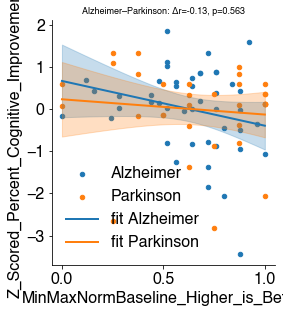

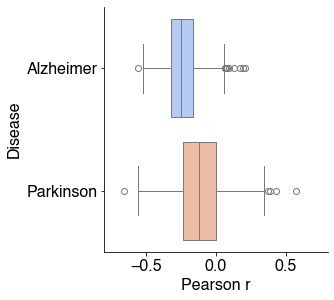

In [77]:
swc = DeltaCorrelationAnalysis(data_df)
swc.run(x=independent_variable, y=dependent_variable, group=group_variable, xlim=(-.8, .8), 
        out_dir='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/cognition_2023/revisions/baselien_cognition')